In [76]:
# Analiza i modyfikacja danych
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ewaluacja
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import precision_score, classification_report
from sklearn.metrics import recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
# machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import GridSearchCV

models = [DecisionTreeClassifier(class_weight='balanced'), RandomForestClassifier(class_weight='balanced'), KNeighborsClassifier(), GaussianNB(),MLPClassifier(random_state=1, max_iter=300) ]
models_names = ['Tree', 'Random forest', 'K Neighbours', 'Naive Bayes', 'MLP']


In [77]:
def read_grouped_data():
    df = pd.read_csv('data/final_data.csv')
    return df.drop(columns=df.columns[0], axis=1)

def calculate_feeling_rate_distribution(df):
    count = df.count()[0]
    data = []
    numbers = df['feeling_rate'].unique()
    for i in numbers:
        occur = df['feeling_rate'].value_counts()[i]
        percent = (occur / count) * 100
        value = round(percent, 2)
        data.append(value)
        
    fig, ax = plt.subplots()
    ax.pie(data, labels=numbers, autopct='%1.1f%%')

def print_df_information(df):
    print(df.head())
    print(df.info())
    print(df.describe())

def change_txt_data(df):
    print(df.describe(include=['O']))
    categoricals = list(df.select_dtypes(include=['O']).columns)
    encoder = OneHotEncoder(sparse_output=False)
    encoded = encoder.fit_transform(df[categoricals])
    train_ohe = pd.DataFrame(encoded, columns=np.hstack(encoder.categories_))
    df = pd.concat((df, train_ohe), axis=1).drop(categoricals, axis=1)
    print(df.head())
    return df

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

def print_balanced_accuracy(balanced_accuracy, balanced_method_name, y):
    plt.bar(models_names, balanced_accuracy)
    addlabels(models_names,balanced_accuracy)

    #giving title to the plot
    plt.title(balanced_method_name)
     
    # giving X and Y labels
    plt.xlabel("Models")
    plt.ylabel(y)
    plt.show

def calculate_metrics(X_train, Y_train, X_test, Y_test, model):
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    #Balanced acuurancy
    balanced_accurancy = round(balanced_accuracy_score(Y_test, Y_pred), 2)
    
    #Clasification report
    report = classification_report(Y_test, Y_pred, output_dict=True)

    return [report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], report['macro avg']['f1-score'], balanced_accurancy]

def calculate_avg_metrics(X_train, Y_train, X_test, Y_test, model):
    metrics = []
    iter = 10
    accuracy = 0
    precision =0
    recall = 0
    f1 = 0
    balanced = 0
    
    for i in range(1, 10):
        metrics = calculate_metrics(X_train, Y_train, X_test, Y_test, model)
        accuracy = accuracy + metrics[0]
        precision = precision +  metrics[1]
        recall = recall + metrics[2]
        f1 = f1 + metrics[3]
        balanced = balanced + metrics[4]
    print([round((accuracy/iter), 2), round((precision/iter), 2), round((recall/iter), 2), round((f1/iter), 2), round((balanced/iter), 2)])
    return [round((accuracy/iter), 2), round((precision/iter), 2), round((recall/iter), 2), round((f1/iter), 2), round((balanced/iter), 2)]

def get_metrics_for_best_tree_parameters(X_train, Y_train, X_test, Y_test, model):
    param_grid = {'ccp_alpha': [0, 0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9, 10, None],
              'criterion' :['gini', 'entropy'],
              'splitter' : ['best', 'random'], 
              'class_weight' : [None, 'balanced']
             }

    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='f1_micro', cv=5, verbose=True)
    grid_search.fit(X_train, Y_train)

    final_model = grid_search.best_estimator_
    return calculate_avg_metrics(X_train, Y_train, X_test, Y_test, model)

def get_metrics_for_best_normal():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=71830, stratify=Y)
    model = DecisionTreeClassifier(random_state=1024)
    return get_metrics_for_best_tree_parameters(X_train, Y_train, X_test, Y_test, model)

def get_metrics_for_best_ros():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=71830, stratify=Y)
    model = DecisionTreeClassifier(random_state=1024)
    
    ros = RandomOverSampler(random_state=0)
    X_resampled, Y_resampled = ros.fit_resample(X_train, Y_train)  
    return get_metrics_for_best_tree_parameters(X_resampled, Y_resampled, X_test, Y_test, model)

def get_metrics_for_best_smote():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=71830, stratify=Y)
    model = DecisionTreeClassifier(random_state=1024)
    
    X_resampled, Y_resampled = SMOTE().fit_resample(X_train, Y_train)    
    return get_metrics_for_best_tree_parameters(X_resampled, Y_resampled, X_test, Y_test, model)

def get_metrics_for_best_adasyn():
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=71830, stratify=Y)
    model = DecisionTreeClassifier(random_state=1024)
    
    X_resampled, Y_resampled = ADASYN().fit_resample(X_train, Y_train)    
    return get_metrics_for_best_tree_parameters(X_resampled, Y_resampled, X_test, Y_test, model)

def get_best_tree_figures_data(accuracy, balanced, f1): 
    normal = get_metrics_for_best_normal()
    ros = get_metrics_for_best_ros()
    smote = get_metrics_for_best_smote()
    adasyn = get_metrics_for_best_adasyn()

    accuracy.append(normal[0])
    accuracy.append(ros[0])
    accuracy.append(smote[0])
    accuracy.append(adasyn[0])
    
    balanced.append(normal[4])
    balanced.append(ros[4])
    balanced.append(smote[4])
    balanced.append(adasyn[4])
    
    f1.append(normal[3])
    f1.append(ros[3])
    f1.append(smote[3])
    f1.append(adasyn[3])
   

def print_comparison_plot(array, title, y):
    x = ['Normal', 'ROS', 'Smote', 'Adasyn']
    print_for_values(array, title, x, y)  

def print_for_values(array, title, x, y):
    plt.bar(x, array)
    addlabels(x, array)

    #giving title to the plot
    plt.title(title)
     
    # giving X and Y labels
    plt.xlabel('Methods')
    plt.ylabel(y)
    plt.show


def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')


       time_of_day
count         4545
unique           6
top           Noon
freq          1142
   steps  heart_rate  raw_intensity  feeling_rate  Early Morning  Evening  \
0      0      115.00          16.00             4            0.0      0.0   
1    181       91.98          37.96             4            0.0      0.0   
2     65       85.43          36.16             4            0.0      0.0   
3     35       87.56          33.18             4            0.0      0.0   
4    397       84.00          49.94             4            0.0      0.0   

   Late Night  Morning  Night  Noon  
0         0.0      1.0    0.0   0.0  
1         0.0      0.0    0.0   1.0  
2         0.0      0.0    0.0   1.0  
3         0.0      0.0    0.0   1.0  
4         0.0      0.0    0.0   1.0  
Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[0.43, 0.2, 0.2, 0.2, 0.21]
Fitting 5 folds for each of 224 candidates, totalling 1120 fits
[0.41, 0.18, 0.18, 0.18, 0.18]
Fitting 5 folds for each of

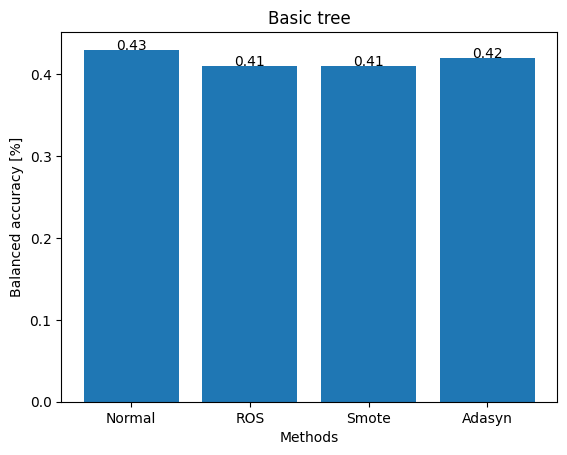

In [78]:
accuracy = []
balanced = []
f1 =[]

train_df = read_grouped_data()
train_df = change_txt_data(train_df)
Y = train_df['feeling_rate'].values
X = train_df.drop(['feeling_rate'], axis=1).values

get_best_tree_figures_data(accuracy, balanced, f1)

print_comparison_plot(accuracy, 'Basic tree', 'Accuracy [%]')

In [79]:
print_comparison_plot(accuracy, 'Basic tree', 'Accuracy [%]')

[0.43, 0.41, 0.41, 0.42]
[0.2, 0.18, 0.19, 0.22]


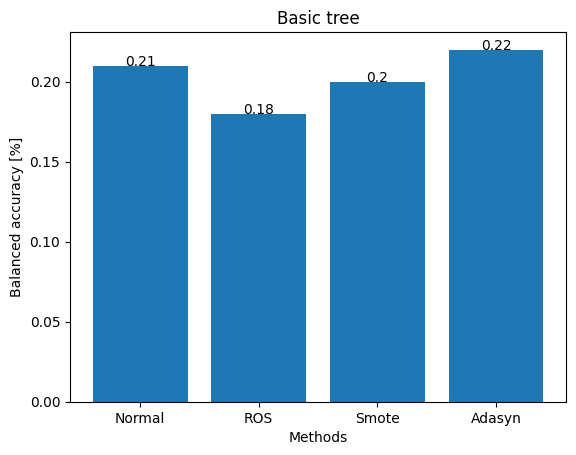

In [80]:
print_comparison_plot(balanced, 'Basic tree', 'Balanced accuracy [%]')

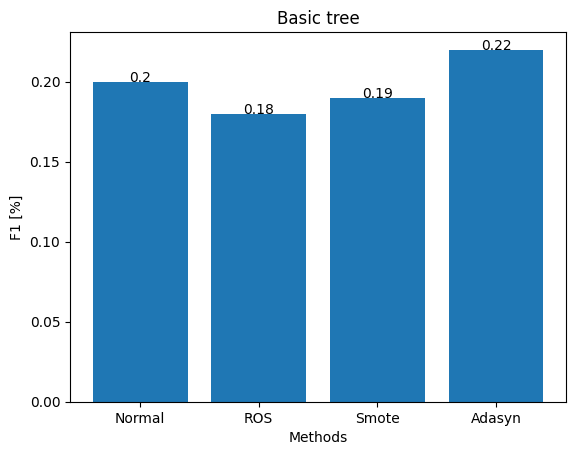

In [81]:
print_comparison_plot(f1, 'Basic tree', 'F1 [%]')